<a href="https://colab.research.google.com/github/Avrutskiy/dneural/blob/master/nn_research_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simple demonstration of the 1st order extended training, which is training a neural network to approximate the target function and its first derivatives. An interesting effect will be observed: the root mean square error of values on the testing set will be lower than the root mean square error of values on the trainig set. However, the precision of values is now only a fraction of the total cost being minimized, and the total cost is of course, larger on the test set.

Code illustrates the paper by V.I. Avrutskiy "Enhancing function approximation abilities of neural networks by training derivatives", courtesy of K. Rybakov

At first, let us make some definitions.

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(X, Y, Z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z)
    plt.show()

The first step is to generate a random target function as 2D Fourier series with up to the 10th harmonics.

In [0]:
np.random.seed(9)
#the number of harmonics
n_order = 10
#random coefficients for Fourier series in range (0,1), to be shifted later
coefs = np.random.rand(n_order, n_order, 4)

def fs_function(coefs, x1, x2):
    f = np.zeros_like(x1)
    for i in range(coefs.shape[0]):
        for j in range(coefs.shape[1]):
            f += (2*coefs[i, j, 0]-1) * np.cos(i*x1) * np.cos(j*x2) / (i + 1) / (j + 1)
            f += (2*coefs[i, j, 1]-1) * np.cos(i*x1) * np.sin(j*x2) / (i + 1) / (j + 1)
            f += (2*coefs[i, j, 2]-1) * np.sin(i*x1) * np.cos(j*x2) / (i + 1) / (j + 1)
            f += (2*coefs[i, j, 3]-1) * np.sin(i*x1) * np.sin(j*x2) / (i + 1) / (j + 1)
            #we shifted "coefs" into (-1,1) range
            #we also divided the corresponding terms by (i+1)(j+1) since this is an asymptotic for fourier coefficients of a smooth function
    if f.shape == ():
        f = float(f)
    return f

Generating the training set as 729 points inside [-1,1]x[-1,1] square.

Number train points: 729


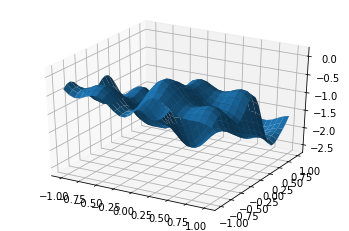

In [3]:
#delta_train is a spacing for cartesian training grid. A small value is subtracted to make sure the boundary points are included in the set
delta_train = 1/13-0.000001
X_train, Y_train = np.meshgrid(np.arange(-1, 1, delta_train), np.arange(-1, 1, delta_train))
Z_train = fs_function(coefs, X_train, Y_train)

#standard deviation to use for normalization of the cost later
std_z_train = Z_train.std()

#arranging the data for training
XY_train_flat = np.hstack([X_train.flatten()[:, None], Y_train.flatten()[:, None]])
Z_train_flat = Z_train.flatten()
print("Number train points:", len(Z_train_flat))

plot3d(X_train, Y_train, Z_train)

Generating the test set with 362404 points (lower delta_test for even more test points)


Number test points: 361201


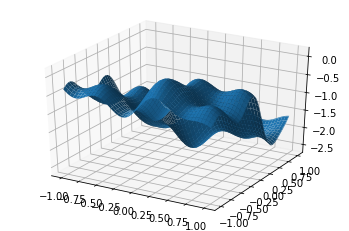

In [4]:
#delta_test is a spacing for cartesian test grid. A small value is subtracted to make sure the boundary points are included in the set
delta_test = 1/300-0.000001
X_test, Y_test = np.meshgrid(np.arange(-1, 1, delta_test), np.arange(-1, 1, delta_test))
XY_test_flat = np.hstack([X_test.flatten()[:, None], Y_test.flatten()[:, None]])

Z_test = fs_function(coefs, X_test, Y_test)
Z_test_flat = Z_test.flatten()
print("Number test points:", len(Z_test_flat))

XY_train_tensor = torch.tensor(XY_train_flat, dtype=torch.float32).cuda()
Z_train_tensor = torch.tensor(Z_train_flat[:, None], dtype=torch.float32).cuda()
XY_test_tensor = torch.tensor(XY_test_flat, dtype=torch.float32).cuda()
Z_test_tensor = torch.tensor(Z_test_flat[:, None], dtype=torch.float32).cuda()

plot3d(X_test, Y_test, Z_test)

Calculating target derivatives with respect to X and Y using finite differences. Due to a finite numerical precision, this works well only for low orders. In this minimal example we train only the first derivatives, so it is acceptable.

In [0]:
#der_delta is a shift, applied to the input set in X and Y directions.
der_delta = 0.000001
X_train_minus = X_train - der_delta
X_train_plus = X_train + der_delta
Y_train_minus = Y_train - der_delta
Y_train_plus = Y_train + der_delta

#we then calculate outputs for shifted values along X and Y axes
Z_train_x_minus = (fs_function(coefs, X_train_minus, Y_train))
Z_train_x_plus = (fs_function(coefs, X_train_plus, Y_train))

Z_train_y_minus = (fs_function(coefs, X_train, Y_train_minus))
Z_train_y_plus = (fs_function(coefs, X_train, Y_train_plus))

#the difference between outputs for shifted grids is divided by 2der_delta 
#to form the first order derivative with stencil (u(x+d)-u(x-d))/(2d)
ZdX_train = (Z_train_x_plus - Z_train_x_minus)/(2*der_delta)
ZdY_train = (Z_train_y_plus - Z_train_y_minus)/(2*der_delta)

#calculating standard deviaitons to normalize the cost funciton later
std_zdx_train = ZdX_train.std()
std_zdy_train = ZdY_train.std()

#flattening and arranging the data for training
ZdX_train_flat = ZdX_train.flatten()
ZdY_train_flat = ZdY_train.flatten()

XminusY_train_flat = np.hstack([X_train_minus.flatten()[:, None], Y_train.flatten()[:, None]])
XplusY_train_flat = np.hstack([X_train_plus.flatten()[:, None], Y_train.flatten()[:, None]])
XYminus_train_flat = np.hstack([X_train.flatten()[:, None], Y_train_minus.flatten()[:, None]])
XYplus_train_flat = np.hstack([X_train.flatten()[:, None], Y_train_plus.flatten()[:, None]])

XminusY_train_tensor = torch.tensor(XminusY_train_flat, dtype=torch.float32).cuda()
XplusY_train_tensor = torch.tensor(XplusY_train_flat, dtype=torch.float32).cuda()
XYminus_train_tensor = torch.tensor(XYminus_train_flat, dtype=torch.float32).cuda()
XYplus_train_tensor = torch.tensor(XYplus_train_flat, dtype=torch.float32).cuda()

ZdX_train_tensor = torch.tensor(ZdX_train_flat[:, None], dtype=torch.float32).cuda()
ZdY_train_tensor = torch.tensor(ZdY_train_flat[:, None], dtype=torch.float32).cuda()


#repeatin the process for the test set
X_test_minus = X_test - der_delta
X_test_plus = X_test + der_delta
Y_test_minus = Y_test - der_delta
Y_test_plus = Y_test + der_delta

Z_test_x_minus = (fs_function(coefs, X_test_minus, Y_test))
Z_test_x_plus = (fs_function(coefs, X_test_plus, Y_test))

Z_test_y_minus = (fs_function(coefs, X_test, Y_test_minus))
Z_test_y_plus = (fs_function(coefs, X_test, Y_test_plus))
ZdX_test = (Z_test_x_plus - Z_test_x_minus)/(2*der_delta)
ZdY_test = (Z_test_y_plus - Z_test_y_minus)/(2*der_delta)

ZdX_test_flat = ZdX_test.flatten()
ZdY_test_flat = ZdY_test.flatten()

XminusY_test_flat = np.hstack([X_test_minus.flatten()[:, None], Y_test.flatten()[:, None]])
XplusY_test_flat = np.hstack([X_test_plus.flatten()[:, None], Y_test.flatten()[:, None]])
XYminus_test_flat = np.hstack([X_test.flatten()[:, None], Y_test_minus.flatten()[:, None]])
XYplus_test_flat = np.hstack([X_test.flatten()[:, None], Y_test_plus.flatten()[:, None]])

XminusY_test_tensor = torch.tensor(XminusY_test_flat, dtype=torch.float32).cuda()
XplusY_test_tensor = torch.tensor(XplusY_test_flat, dtype=torch.float32).cuda()
XYminus_test_tensor = torch.tensor(XYminus_test_flat, dtype=torch.float32).cuda()
XYplus_test_tensor = torch.tensor(XYplus_test_flat, dtype=torch.float32).cuda()

ZdX_test_tensor = torch.tensor(ZdX_test_flat[:, None], dtype=torch.float32).cuda()
ZdY_test_tensor = torch.tensor(ZdY_test_flat[:, None], dtype=torch.float32).cuda()

Constructing a network with 2\*,128,128,128,128,1\* configuration.

In [0]:
model = nn.Sequential()
model.add_module("dense0", nn.Linear(2, 128))
model.add_module("sigmoid0", nn.Sigmoid())
model.add_module("dense1", nn.Linear(128, 128))
model.add_module("sigmoid1", nn.Sigmoid())
model.add_module("dense2", nn.Linear(128, 128))
model.add_module("sigmoid2", nn.Sigmoid())
model.add_module("dense3", nn.Linear(128, 128))
model.add_module("sigmoid3", nn.Sigmoid())
model.add_module("dense4", nn.Linear(128, 128))
model.add_module("sigmoid4", nn.Sigmoid())
model.add_module("dense5", nn.Linear(128, 1))

To keep the code simple and versatile, the derivatives will be trained using the finite differences as well. This requires calculating two shifted outputs of a network and then constructing the trainable cost using their difference divided by 2*der_delta. This method was verified to give exactly the same gradient as the quasi-analytical approach presented in the paper. Due to a finite numerical precision, this works well only for lower orders.

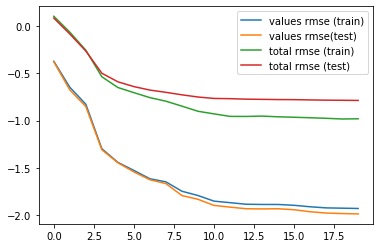

Iteration: 1000 

RMSE for values (train): 0.0116988765 	RMSE for X-derivative (train): 0.07855132 	RMSE for Y-derivative (train): 0.06784336
RMSE for values (test): 0.010248 	RMSE for X-derivative (test): 0.141760 	RMSE for Y-derivative (test): 0.080721
Root mean of the total cost (train): 0.104450 	Root mean of total cost (test) 0.163453


In [7]:
from IPython.display import clear_output

#choosing RProp as the training routine
opt = torch.optim.Rprop(model.parameters(), lr=0.0002, step_sizes=(0, 10))
#the number of training epochs is the same as used for Table I of the paper.
max_n_epochs = 1000

#how many epochs between checking the test set values
n_epochs_check = 50

#loss history to plot graphs
loss_history = []
loss_history_total = []
loss_history_test = []
loss_history_test_total = []

for i in range(max_n_epochs):
    
    opt.zero_grad()
    model.train(True)
    
    #constructing terms for the cost function, the first one is obvious
    Z_train_pred = model.cuda()(XY_train_tensor)

    #the following two are the first derivatives according to (u(x+d)-u(x-d))/(2d) stencil
    ZdX_train_pred = (model.cuda()(XplusY_train_tensor) - model.cuda()(XminusY_train_tensor))/(2*der_delta)
    ZdY_train_pred = (model.cuda()(XYplus_train_tensor) - model.cuda()(XYminus_train_tensor))/(2*der_delta)
    
    #constructing trainable losses
    loss_f = F.mse_loss(Z_train_pred, Z_train_tensor) / std_z_train**2
    loss_fdx = F.mse_loss(ZdX_train_pred, ZdX_train_tensor) / std_zdx_train**2
    loss_fdy = F.mse_loss(ZdY_train_pred, ZdY_train_tensor) / std_zdy_train**2
    
    #the total cost to be trained
    loss = loss_f + loss_fdx + loss_fdy
    
    loss.backward()
    opt.step()
    
    #the following code calculates the test set values every n_epochs_check epochs
    #and also makes plots
    if (i + 1) % n_epochs_check == 0:
        clear_output(True)
        model.train(False)

        #the train error of values and the total error are already calculated
        error = np.sqrt(loss_f.cpu().data.numpy());
        error_train_total = np.sqrt(loss.cpu().data.numpy());

        #calculating the test set deviations
        Z_test_pred = model.cuda()(XY_test_tensor)
        error_test = np.sqrt(F.mse_loss(Z_test_pred, Z_test_tensor).cpu().data.numpy()) / std_z_train
        
        #for derivatives we use the finite difference stencil again
        ZdX_test_pred = (model.cuda()(XplusY_test_tensor) - model.cuda()(XminusY_test_tensor))/(2*der_delta)
        error_dx_test = np.sqrt(F.mse_loss(ZdX_test_pred, ZdX_test_tensor).cpu().data.numpy()) / std_zdx_train

        ZdY_test_pred = (model.cuda()(XYplus_test_tensor) - model.cuda()(XYminus_test_tensor))/(2*der_delta)
        error_dy_test = np.sqrt(F.mse_loss(ZdY_test_pred, ZdY_test_tensor).cpu().data.numpy()) / std_zdy_train
        
        #combining them into the total error, which will be overfit on the test
        error_test_total = np.sqrt(error_test**2+error_dx_test**2+error_dy_test**2)

        loss_history.append(np.log10(error))
        loss_history_total.append(np.log10(error_train_total))
        loss_history_test.append(np.log10(error_test))
        loss_history_test_total.append(np.log10(error_test_total))

        plt.plot(loss_history,label='values rmse (train)')
        plt.plot(loss_history_test,label='values rmse(test)')
        plt.plot(loss_history_total,label='total rmse (train)')
        plt.plot(loss_history_test_total,label='total rmse (test)')
        plt.legend()
        plt.show()
        
        print("Iteration:", i + 1, "\n")
        print("RMSE for values (train):", np.sqrt(loss_f.cpu().data.numpy()), "\tRMSE for X-derivative (train):", np.sqrt(loss_fdx.cpu().data.numpy()), "\tRMSE for Y-derivative (train):", np.sqrt(loss_fdy.cpu().data.numpy()))
        print("RMSE for values (test):", '{:f}'.format(error_test), "\tRMSE for X-derivative (test):", '{:f}'.format(error_dx_test), "\tRMSE for Y-derivative (test):", '{:f}'.format(error_dy_test))
        print("Root mean of the total cost (train):", '{:f}'.format(np.sqrt(loss.cpu().data.numpy())),"\tRoot mean of total cost (test)",'{:f}'.format(error_test_total))


We can see that the total cost is overfit as one could predict by comparing 729 point data set with a network with ~70000 weights. However, if training values is the thing we are interested in, there is no overfitting of values and the precision is quite decent.

Let us examine the deviation of values for the train set more closely.

Train set maximum negative deviation: -0.047315

Train set maximum positive deviation: 0.056427

Train set standard deviation: 0.011710


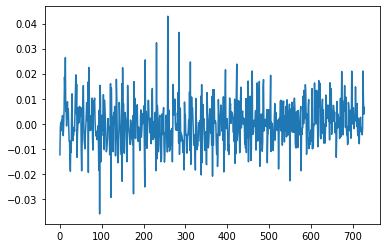

In [8]:
ans=model.cuda()(XY_train_tensor)-Z_train_tensor
plt.plot(ans.cpu().data.numpy())
#we will divide all values by the standard deviation of the target
print("Train set maximum negative deviation:",'{:f}'.format(ans.data.cpu().min().item()/std_z_train))
print("\nTrain set maximum positive deviation:",'{:f}'.format(ans.data.cpu().max().item()/std_z_train))
print("\nTrain set standard deviation:",'{:f}'.format(ans.data.cpu().std().item()/std_z_train))

And the deviations of values for the test set: 

Test set maximum negative deviation: -0.049830

Test set maximum positive deviation: 0.056443

Test set standard deviation: 0.010248


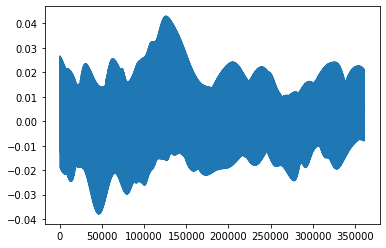

In [9]:
ans=model.cuda()(XY_test_tensor)-Z_test_tensor
plt.plot(ans.cpu().data.numpy())
#we will divide all values by the standard deviation of the target
print("Test set maximum negative deviation:",'{:f}'.format(ans.data.cpu().min().item()/std_z_train))
print("\nTest set maximum positive deviation:",'{:f}'.format(ans.data.cpu().max().item()/std_z_train))
print("\nTest set standard deviation:",'{:f}'.format(ans.data.cpu().std().item()/std_z_train))

As can be observed, even the maximum deviations of values on the train set are close to those of the test set. Since the test set is very dense, this result excludes the possibiliy of "spikes" for deviations, observed by Pukrittayakamee et.al, and also corrects their claim that training derivatives on itself produces a new type of overfitting. 

The particular values of precisions may vary with random seed and training attempts, but in general the effects are as described.

We can also compare the previous result with the regular training.

In [0]:
model0 = nn.Sequential()
model0.add_module("dense0", nn.Linear(2, 128))
model0.add_module("sigmoid0", nn.Sigmoid())
model0.add_module("dense1", nn.Linear(128, 128))
model0.add_module("sigmoid1", nn.Sigmoid())
model0.add_module("dense2", nn.Linear(128, 128))
model0.add_module("sigmoid2", nn.Sigmoid())
model0.add_module("dense3", nn.Linear(128, 128))
model0.add_module("sigmoid3", nn.Sigmoid())
model0.add_module("dense4", nn.Linear(128, 128))
model0.add_module("sigmoid4", nn.Sigmoid())
model0.add_module("dense5", nn.Linear(128, 1))

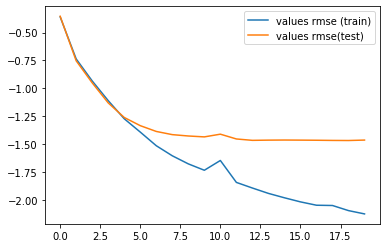

Iteration: 1000 

RMSE for values (train): 0.007467
RMSE for values (test): 0.034307


In [11]:
opt0 = torch.optim.Rprop(model0.parameters(), lr=0.0002, step_sizes=(0, 10))

max_n_epochs = 1000
n_epochs_check = 50

loss0_history = []
loss0_history_test = []

for i in range(max_n_epochs):
    
    opt0.zero_grad()
    
    model0.train(True)
    
    Z_train_pred = model0.cuda()(XY_train_tensor)    
    loss_f = F.mse_loss(Z_train_pred, Z_train_tensor) / std_z_train**2 
    loss = loss_f
    
    loss.backward()
    opt0.step()
    
    if (i + 1) % n_epochs_check == 0:
        clear_output(True)
        model0.train(False)
        
        Z_train_pred = model0.cuda()(XY_train_tensor)
        error = np.sqrt(F.mse_loss(Z_train_pred, Z_train_tensor).cpu().data.numpy()) / std_z_train
        
        Z_test_pred = model0.cuda()(XY_test_tensor)
        error_test = np.sqrt(F.mse_loss(Z_test_pred, Z_test_tensor).cpu().data.numpy()) / std_z_train

        loss0_history.append(np.log10(error))
        loss0_history_test.append(np.log10(error_test))

        plt.plot(loss0_history,label='values rmse (train)')
        plt.plot(loss0_history_test,label='values rmse(test)')
        plt.legend()
        plt.show()
        
        print("Iteration:", i + 1, "\n")
        print("RMSE for values (train):", '{:f}'.format(error))
        print("RMSE for values (test):", '{:f}'.format(error_test))


We observe the overfitting of values as expected.